# Problem Set 4

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import seaborn as sns

%matplotlib inline

In [2]:
dataDir = "./data/"
mnistDir = dataDir + "mnist/"

# Question 1




In [3]:
def readData(images_file, labels_file):
    x = np.loadtxt(images_file, delimiter=',')
    y = np.loadtxt(labels_file, delimiter=',')
    return x, y

def nn_test(data, labels, params):
    h, output, cost = forward_prop(data, labels, params)
    accuracy = compute_accuracy(output, labels)
    return accuracy

def compute_accuracy(output, labels):
    accuracy = (np.argmax(output,axis=1) == np.argmax(labels,axis=1)).sum() * 1. / labels.shape[0]
    return accuracy

def one_hot_labels(labels):
    one_hot_labels = np.zeros((labels.size, 10))
    one_hot_labels[np.arange(labels.size),labels.astype(int)] = 1
    return one_hot_labels


## Part A

* softmax

$$
softmax(x)_i = \frac{\exp x_i}{\sum_{i=1}^{d} \exp x_i} = \frac{\exp \left(x_i - \max x \right)}{\sum_{i=1}^{d} \exp \left(x_i - \max x \right)}
$$

to prevent overflow you subtract the largest value as explained [here](https://stackoverflow.com/questions/42599498/numercially-stable-softmax). 

In [4]:
def softmax(x):
    """
    Compute softmax function for input. 
    Use tricks from previous assignment to avoid overflow
    """
	### YOUR CODE HERE
    z = x - x.max(axis=1)[:,np.newaxis]
    numerator = np.exp(z)
    denominator = numerator.sum(axis=1)[:,np.newaxis]
    s = numerator/denominator
	### END YOUR CODE
    return s

* sigmoid

$$
\sigma(x) = \frac{1}{1 + \exp -x} = \frac{\exp x}{1 + \exp x}
$$

To prevent overflow you calculate $x_i$ differently based off of where or not $x_i$ is positive or negative [(source)](https://stackoverflow.com/questions/51976461/optimal-way-of-defining-a-numerically-stable-sigmoid-function-for-a-list-in-pyth). If $x_i \ge 0$ use the middle term above and use the right hand term otherwise.

In [5]:
def sigmoid(x):
    """
    Compute the sigmoid function for the input here.
    """
    ### YOUR CODE HERE

    # init s
    s = np.zeros(x.shape, dtype=float)
    
    # find positive values
    pos = x >= 0
    # negate to get negative values
    neg = np.logical_not(pos)
    
    #calculate sigmoid for positive values
    s[pos] = 1 / (1 + np.exp(-x[pos]))
    # calculate sigmoid for negative values
    s[neg] = np.exp(x[neg]) / (1 + np.exp(x[neg]))
    ### END YOUR CODE
    return s

* foward propogaton

$$
z^{[1]} = XW^{[1]} + b^{[1]}
$$

$$
h = \sigma(z^{[1]})
$$

$$
z^{[2]} = hW^{[2]} + b^{[2]}
$$

$$
\hat{y} = softmax(z^{[2]})
$$

$$
J = loss = \sum_{i=1}^m CE(y^{(i)}, \hat{y}^{(i)}) = \sum_{i=1}^m\sum_{k=1}^K y^{(i)}_k \log \hat{y}^{(i)}_k
$$


In [6]:
def forward_prop(data, labels, params):
    """
    return hidder layer, output(softmax) layer and loss
    """
    W1 = params['W1']
    b1 = params['b1']
    W2 = params['W2']
    b2 = params['b2']

    ### YOUR CODE HERE
    
    # calculate values
    z1 = data@W1 + b1
    h = sigmoid(z1)
    z2 = h@W2 + b2
    y = softmax(z2)
    
    # calculate loss
    cost = -(labels*np.log(y)).sum() / y.shape[0]
    ### END YOUR CODE
    return h, y, cost

* back propogation

back propogation algorithm can be found on page 19 of the deep learning notes.

For the derivations we will assume $m = 1$, so that when the derivatives are implimented we will just be summing $m$ values.


1. $\delta^{[2]}$

$$
\frac{\partial \hat{y}_i}{\partial z^{[2]}_j} = \frac{\partial}{\partial z^{[2]}_j} softmax(z^{[2]})_i
$$

If $i = j$:

$$
\frac{\partial \hat{y}_i}{\partial z^{[2]}_j}  
= 
\frac{\partial}{\partial z^{[2]}_j} \frac{\exp (x_i)}{\sum_{j=1}^k exp (x_j)} 
$$


$$
= \frac{\exp(x_i)\sum_{j=1}^k exp (x_j) - \exp(x_i)\exp(x_j)}{\left(\sum_{j=1}^k exp (x_j)\right)^2} 
$$

$$
= \frac{\exp(x_i)}{\sum_{j=1}^k exp (x_j)}\cdot \frac{\sum_{j=1}^k exp (x_j) - \exp(x_i)}{\sum_{j=1}^k exp (x_j)}
$$

$$
= \hat{y_i}(1-\hat{y_i})
$$

If $i \neq j$:

$$
\frac{\partial \hat{y}_i}{\partial z^{[2]}_j}
=
\frac{0 - \exp(x_i)\exp(x_j)}{\left(\sum_{j=1}^k exp (x_j)\right)^2}
=
\frac{\exp(x_i)}{\sum_{j=1}^k exp (x_j)} \frac{\exp(x_j)}{\sum_{j=1}^k exp (x_j)}
=
- \hat{y}_i \hat{y}_j
$$

----


$$
\frac{\partial J}{\partial z^{[2]}_i} = - \frac{\partial}{\partial z^{[2]}_i} \sum_{k=1}^{K} y_k \log \hat{y}^{(i)}_k
$$


$$
= - \sum_{k=1}^{K} y_k \frac{1}{\hat{y}_k} \frac{\partial \hat{y}_k}{\partial z^{[2]}_i}
$$

$$
= - \sum_{k=1, k \neq i}^{K} \frac{y_k}{\hat{y}_k} \cdot (- \hat{y}_i \hat{y}_k) - \frac{y_i}{\hat{y}_i}\hat{y_i}(1-\hat{y_i})
$$

$$
= \sum_{k=1, k \neq i}^{K} y_k\hat{y}_i + y_i\hat{y}_i - y_i
$$

$$
= \sum_{k=1}^{K} y_k\hat{y}_i  - y_i
$$

$$
= \hat{y}_i \sum_{k=1}^{K} y_k  - y_i
$$

$$
= \hat{y}_i  - y_i
$$

Thus we have shown $\delta^{[2]} = \frac{\partial J}{\partial z^{[2]}} = \hat{y} - y$.

---

2. $\delta^{[1]}$

$$
\delta^{[1]} = \left(W^{[2]T}\delta^{[2]}\right) \odot \sigma'(z^{[1]})
$$

$$
= \left(W^{[2]T}\delta^{[2]}\right) \odot \sigma(z^{[1]}) \odot \left(1-\sigma(z^{[1]})\right)
$$

$$
= \left(W^{[2]T}\delta^{[2]}\right) \odot h \odot (1-h)
$$

Thus we have shown $\delta^{[1]} = \left(W^{[2]T}\delta^{[2]}\right) \odot h \odot (1-h)$. 

Note: the lecture notes are for SGD and here we are performing minibatching. This changes the dimensions of $\delta$ so the way $\delta^{[1]}$ is calculated is different than what is listed above.

3. 

NOTE: I could do more derivations here

show regularization

In [7]:
def backward_prop(data, labels, params, regularization):
    """
    return gradient of parameters
    """
    W1 = params['W1']
    b1 = params['b1']
    W2 = params['W2']
    b2 = params['b2']

    ### YOUR CODE HERE
    
    # batch size
    B = data.shape[0]
    
    # foward pass
    h, y_hat, J = forward_prop(data, labels, params)
    # perform foward step
    
    # calculate deltas
    delta2 = y_hat - labels
    delta1 = delta2 @ W2.T * (h*(1-h)) # h(1-h) is correctly broadcasted
    
    # calculate gradients
    gradW1 = data.T @ delta1/B + 2*regularization*W1
    gradW2 = h.T @ delta2/B + 2*regularization*W2
    gradb1 = delta1.sum(axis = 0)/B #keepdims=True
    gradb2 = delta2.sum(axis = 0)/B #keepdims=True
    
    
    ### END YOUR CODE

    grad = {}
    grad['W1'] = gradW1
    grad['W2'] = gradW2
    grad['b1'] = gradb1
    grad['b2'] = gradb2

    return grad

In [8]:
def nn_train(trainData, trainLabels, devData, devLabels, regularization = 0):
    (m, n) = trainData.shape
    num_hidden = 300
    learning_rate = 5
    params = {}

    ### YOUR CODE HERE
    d = n # dimensions of data (784)
    K = trainLabels.shape[1] # dimensions of y (10, 0-9) 
    epochs = 30
    B = 1000 # minibatch size
    epoch_iters = int(m/B) # number of iterations for each epoch
    
    # Initialize the weights of the network by sampling values from a standard normal distribution
    params['W1'] = np.random.standard_normal((d, num_hidden))
    params['W2'] = np.random.standard_normal((num_hidden, K))
    
    # Initialize the bias/intercept term to 0.
    params['b1'] = np.zeros(num_hidden, dtype=float)
    params['b2'] = np.zeros(K, dtype=float)

    # data frame to store CE loss and accuracy metrics
    metrics = pd.DataFrame({"epoch":range(epochs), 
                            "train_CE":np.nan, 
                            "val_CE":np.nan, 
                            "train_accuracy":np.nan, 
                            "val_accuracy":np.nan})

    
    # mini batch with epochs
    print("epoch ", end = "")
    for epoch_num in range(epochs):
        if epoch_num % 10 == 9:
            print(epoch_num)
            print("epoch ", end = "")
        else:
            print(epoch_num, end = ", ")
        
        # running minibatching
        for batch_num in range(epoch_iters):
            dataBatch = trainData[batch_num*B:(batch_num+1)*B]
            labelsBatch = trainLabels[batch_num*B:(batch_num+1)*B]
            grad = backward_prop(dataBatch, labelsBatch, params, regularization)
            # update params
            for key in params.keys():
                params[key] -= learning_rate * grad[key]
        # once epoch is over collect metrics
        h, y, cost = forward_prop(trainData, trainLabels, params)
        metrics.loc[epoch_num, "train_CE"] = cost
        metrics.loc[epoch_num, "train_accuracy"] = compute_accuracy(y, trainLabels)
        h, y, cost = forward_prop(devData, devLabels, params)
        metrics.loc[epoch_num, "val_CE"] = cost
        metrics.loc[epoch_num, "val_accuracy"] = compute_accuracy(y, devLabels)
    print("training complete")
    ### END YOUR CODE

    return params, metrics

In [9]:
def main():
    np.random.seed(100)
    trainData, trainLabels = readData(mnistDir+'images_train.csv', mnistDir+'labels_train.csv')
    trainLabels = one_hot_labels(trainLabels)
    p = np.random.permutation(60000)
    trainData = trainData[p,:]
    trainLabels = trainLabels[p,:]

    devData = trainData[0:10000,:]
    devLabels = trainLabels[0:10000,:]
    trainData = trainData[10000:,:]
    trainLabels = trainLabels[10000:,:]

    mean = np.mean(trainData)
    std = np.std(trainData)
    trainData = (trainData - mean) / std
    devData = (devData - mean) / std

    testData, testLabels = readData(mnistDir+'images_test.csv', mnistDir+'labels_test.csv')
    testLabels = one_hot_labels(testLabels)
    testData = (testData - mean) / std
	
    params = nn_train(trainData, trainLabels, devData, devLabels)


    readyForTesting = False
    if readyForTesting:
        accuracy = nn_test(testData, testLabels, params)
        print(f"test accuracy: {accuracy.round(3)}")
	#print ('Test accuracy: %f'%accuracy)

#if __name__ == '__main__':
#    main()


In [10]:
# main function stuff to input data
np.random.seed(100)
trainData, trainLabels = readData(mnistDir+'images_train.csv', mnistDir+'labels_train.csv')
trainLabels = one_hot_labels(trainLabels)
p = np.random.permutation(60000)
trainData = trainData[p,:]
trainLabels = trainLabels[p,:]

devData = trainData[0:10000,:]
devLabels = trainLabels[0:10000,:]
trainData = trainData[10000:,:]
trainLabels = trainLabels[10000:,:]

mean = np.mean(trainData)
std = np.std(trainData)
trainData = (trainData - mean) / std
devData = (devData - mean) / std

testData, testLabels = readData(mnistDir+'images_test.csv', mnistDir+'labels_test.csv')
testLabels = one_hot_labels(testLabels)
testData = (testData - mean) / std

In [11]:
# calcualte parameters, no regularization
params0, metrics0 = nn_train(trainData, trainLabels, devData, devLabels, regularization = 0)

epoch 0, 1, 2, 3, 4, 5, 6, 7, 8, 9
epoch 10, 11, 12, 13, 14, 15, 16, 17, 18, 19
epoch 20, 21, 22, 23, 24, 25, 26, 27, 28, 29
epoch training complete


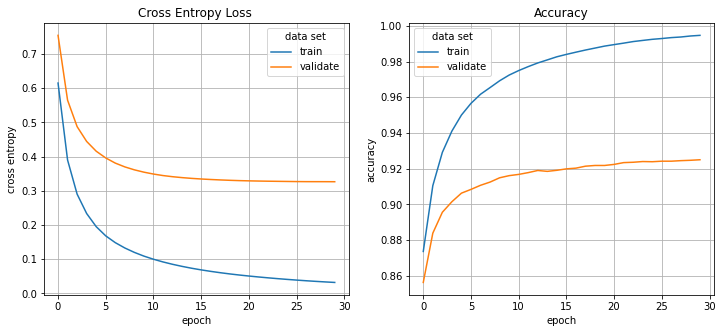

In [12]:
df_CE = metrics0.rename(columns={"train_CE":"train","val_CE":"validate"}).melt(id_vars=['epoch'], value_vars=["train", "validate"])
df_accuracy = metrics0.rename(columns={"train_accuracy":"train","val_accuracy":"validate"}).melt(id_vars=['epoch'], value_vars=["train", "validate"])

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.lineplot(ax = axes[0], x = "epoch",y = "value", hue = "variable", data = df_CE)
axes[0].grid(True)
axes[0].set_xlabel("epoch")
axes[0].set_ylabel("cross entropy")
axes[0].set_title("Cross Entropy Loss ")
axes[0].legend(title = "data set")

sns.lineplot(ax = axes[1], x = "epoch",y = "value", hue = "variable", data = df_accuracy)
axes[1].grid(True)
axes[1].set_xlabel("epoch")
axes[1].set_ylabel("accuracy")
axes[1].set_title("Accuracy")
axes[1].legend(title = "data set")

## Part B

In [13]:
# calculate parameters with regularization
params1, metrics1 = nn_train(trainData, trainLabels, devData, devLabels, regularization = 0.0001)

epoch 0, 1, 2, 3, 4, 5, 6, 7, 8, 9
epoch 10, 11, 12, 13, 14, 15, 16, 17, 18, 19
epoch 20, 21, 22, 23, 24, 25, 26, 27, 28, 29
epoch training complete


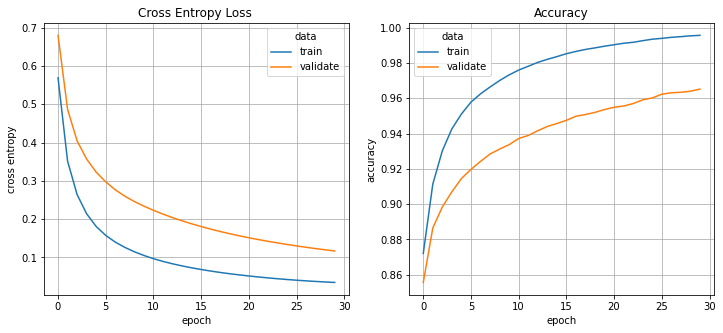

In [14]:
df_CE = metrics1.rename(columns={"train_CE":"train","val_CE":"validate"}).melt(id_vars=['epoch'], value_vars=["train", "validate"])
df_accuracy = metrics1.rename(columns={"train_accuracy":"train","val_accuracy":"validate"}).melt(id_vars=['epoch'], value_vars=["train", "validate"])

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.lineplot(ax = axes[0], x = "epoch",y = "value", hue = "variable", data = df_CE)
axes[0].grid(True)
axes[0].set_xlabel("epoch")
axes[0].set_ylabel("cross entropy")
axes[0].set_title("Cross Entropy Loss ")
axes[0].legend(title = "data")

sns.lineplot(ax = axes[1], x = "epoch",y = "value", hue = "variable", data = df_accuracy)
axes[1].grid(True)
axes[1].set_xlabel("epoch")
axes[1].set_ylabel("accuracy")
axes[1].set_title("Accuracy")
axes[1].legend(title = "data")

## Part C

In [15]:
accuracy0 = nn_test(testData, testLabels, params0)
print(f"The test accuracy without regularization is {accuracy0.round(3)}")

The test accuracy without regularization is 0.929


In [16]:
accuracy1 = nn_test(testData, testLabels, params1)
print(f"The test accuracy with regularization is {accuracy1.round(3)}")

The test accuracy with regularization is 0.968


# Question 2

Assume $\theta^*$ is the set of parameters obtained by maximizing an EM algorithm. We wts that $\nabla_\theta \ell(\theta^*) = 0$.

Let $Q_i^*(z) = p(z^{(i)} \vert x^{(i)}; \theta^*)$. 

Then we have 

$$
\sum_{i=1}^{m} ELBO(x^{(i)}, Q_i^*, \theta) 
= 
\sum_{i=1}^{m}\sum_{z^{(i)}} Q_i^* (z^{(i)}) \log \frac{p(x^{(i)}, z^{(i)}; \theta)}{Q_i^* (z^{(i)})} 
= 
\sum_{i=1}^{m}\sum_{z^{(i)}} Q_i^* (z^{(i)}) \left(\log p(x^{(i)}, z^{(i)}; \theta) - \log Q_i^* (z^{(i)})\right)
$$

Taking the gradient and setting $\theta$ to $\theta^*$ we get

$$
0 
=
\nabla_\theta \sum_{i=1}^{m} ELBO(x^{(i)}, Q_i^*, \theta) \vert_{\theta = \theta^*}
=
\nabla_\theta \left(\sum_{i=1}^{m}\sum_{z^{(i)}} Q_i^* (z^{(i)}) \left(\log p(x^{(i)}, z^{(i)}; \theta) - \log Q_i^* (z^{(i)})\right)\right)\vert_{\theta = \theta^*}
$$

$$
= \sum_{i=1}^{m} \sum_{z^{(i)}} Q_i^*(z^{(i)}) \frac{\nabla_\theta p(x^{(i)}, z^{(i)}; \theta) \vert_{\theta = \theta^*}}{p(x^{(i)}, z^{(i)}; \theta^*)}
$$

$$
= \sum_{i=1}^{m} \sum_{z^{(i)}} \frac{p(x^{(i)}, z^{(i)}; \theta^*)}{p(x^{(i)}; \theta^*)} \frac{\nabla_\theta p(x^{(i)}, z^{(i)}; \theta) \vert_{\theta = \theta^*}}{p(x^{(i)}, z^{(i)}; \theta^*)}
$$

$$
= \sum_{i=1}^{m} \sum_{z^{(i)}} \frac{\nabla_\theta p(x^{(i)}, z^{(i)}; \theta) \vert_{\theta = \theta^*}}{p(x^{(i)}; \theta^*)}
$$

$$
= \sum_{i=1}^{m} \frac{1}{p(x^{(i)}; \theta^*)} \nabla_\theta \sum_{z^{(i)}}  p(x^{(i)}, z^{(i)}; \theta) \vert_{\theta = \theta^*}
$$

$$
= \sum_{i=1}^{m} \frac{\nabla_\theta p(x^{(i)}; \theta) \vert_{\theta = \theta^*}}{p(x^{(i)}; \theta^*)}
$$

$$
= \sum_{i=1}^{m} \nabla_\theta (\log p(x^{(i)}; \theta))\vert_{\theta = \theta^*}
$$

$$
= \nabla_\theta \sum_{i=1}^{m} (\log p(x^{(i)}; \theta))\vert_{\theta = \theta^*}
$$

$$
= \nabla_\theta \ell(\theta^*)
$$

Therefore we have shown $\nabla_\theta \ell(\theta^*) = 0$ thus $\theta^*$ maximizes the likelihood, which is what we wanted to show. 

# Question 3

$$
f_u(x) = \arg \min_{\nu \in \mathcal{V}} \Vert x - \nu \Vert^2 = (u^Tx) u
$$

$$
u = \arg \min_{u:u^Tu=1} \sum_{i=1}^{m} \Vert x^{(i)}-f_{u}(x^{(i)}) \Vert^2_2
$$

$$
= \arg \min_{u:u^Tu=1} \sum_{i=1}^{m} \Vert x^{(i)}- u^Tx^{(i)} u \Vert^2_2
$$

$$
= \arg \min_{u:u^Tu=1} \sum_{i=1}^{m}  \left(x^{(i)}- u^Tx^{(i)}u\right)^T \left(x^{(i)}- u^Tx^{(i)}u\right)
$$

$$
= \arg \min_{u:u^Tu=1} \sum_{i=1}^{m}  \left(x^{(i)T}- u^Tx^{(i)}u^T\right) \left(x^{(i)}- u^Tx^{(i)}u\right)
$$

$$
= \arg \min_{u:u^Tu=1} \sum_{i=1}^{m}  \left(x^{(i)T}x^{(i)} - x^{(i)T}u^Tx^{(i)}u - u^Tx^{(i)}u^Tx^{(i)} + u^Tx^{(i)}u^T \cdot u^Tx^{(i)}u \right)
$$

$$
= \arg \min_{u:u^Tu=1} \sum_{i=1}^{m}  \left(x^{(i)T}x^{(i)} - u^Tx^{(i)}x^{(i)T}u - u^Tx^{(i)}x^{(i)T}u^T + u^Tx^{(i)} x^{(i)T}u u^Tu \right)
$$

$$
= \arg \min_{u:u^Tu=1} \sum_{i=1}^{m}  \left(x^{(i)T}x^{(i)} - 2u^Tx^{(i)}x^{(i)T}u + u^Tx^{(i)}x^{(i)T}u \right)
$$

$$
= \arg \min_{u:u^Tu=1} \sum_{i=1}^{m}  \left(x^{(i)T}x^{(i)} - u^Tx^{(i)}x^{(i)T}u\right)
$$

$$
= \arg \min_{u:u^Tu=1} \sum_{i=1}^{m} - u^Tx^{(i)}x^{(i)T}u
$$

$$
= \arg \max_{u:u^Tu=1} u^T \left(\sum_{i=1}^{m} x^{(i)}x^{(i)T}\right)u
$$

$$
= \arg \max_{u:u^Tu=1} u^T \left(\frac{1}{m} \sum_{i=1}^{m} x^{(i)}x^{(i)T}\right)u
$$

Which is the same as obective as PCA. Therefore we have shown that $u$ minimizes the mean squared error between projected points and origional points corresponds to the first principal component for the data, which is what we wanted to show.

# Question 4

In [17]:
import sounddevice as sd
import numpy as np

Fs = 11025

def normalize(dat):
    return 0.99 * dat / np.max(np.abs(dat))

def load_data():
    mix = np.loadtxt(dataDir+'mix.dat')
    return mix

def play(vec):
    sd.play(vec, Fs, blocking=True)

In [18]:
def unmixer(X):
    M, N = X.shape
    W = np.eye(N)

    anneal = [0.1, 0.1, 0.1, 0.05, 0.05, 0.05, 0.02, 0.02, 0.01, 0.01,
              0.005, 0.005, 0.002, 0.002, 0.001, 0.001]
    print('Separating tracks ...')
    ######## Your code here ##########
    
    np.random.seed(1234)
    
    # will do SGD
    for alpha in anneal:
        permutation = np.random.permutation(M) # (remark on lecture notes 11 pg 6)
        for p in permutation:
            W += alpha * (np.outer(1 - 2 * sigmoid(W @ X[p]), X[p]) + np.linalg.inv(W.T))
    ###################################
    return W

In [19]:
def unmix(X, W):
    S = np.zeros(X.shape)

    ######### Your code here ##########
    S = X @ W.T
    ##################################
    return S

In [20]:
def main():
    X = normalize(load_data())

    for i in range(X.shape[1]):
        print('Playing mixed track %d' % i)
        play(X[:, i])

    W = unmixer(X)
    S = normalize(unmix(X, W))

    for i in range(S.shape[1]):
        print('Playing separated track %d' % i)
        play(S[:, i])

if __name__ == '__main__':
    main()

Playing mixed track 0
Playing mixed track 1
Playing mixed track 2
Playing mixed track 3
Playing mixed track 4
Separating tracks ...
Playing separated track 0
Playing separated track 1
Playing separated track 2
Playing separated track 3
Playing separated track 4


The sounds are partitioned. They all are distinguishable but sound 3 has some noticable error.

# Question 5

## Part A

$$
V' = B(V)
$$

$$
\Vert B(V_1) - B(V_2) \Vert_\infty = \Vert V_1' - V_2' \Vert_\infty = \max_{s \in S} \vert V_1'(s) - V_2'(s) \vert
$$

Let $\max_{s \in S} \vert V_1'(s) - V_2'(s) \vert = \vert V_1'(s^*) - V_2'(s^*) \vert$. WLOG assume $\vert V_1'(s^*) - V_2'(s^*) \vert = V_1'(s^*) - V_2'(s^*)$. Thus we get

$$
V_1'(s^*) - V_2'(s^*) 
= 
R(s^*) + \gamma \max_{a \in A} \sum_{s' \in S} P_{s a}(s') V_1(s') 
-
\left(
R(s^*) + \gamma \max_{a \in A} \sum_{s' \in S} P_{s a}(s') V_2(s')
\right)
$$

$$
= \gamma \left(
\max_{a \in A} \sum_{s' \in S} P_{s a}(s') V_1(s') 
-
\max_{a \in A} \sum_{s' \in S} P_{s a}(s') V_2(s')
\right)
$$

Define $a^*_1, a^*_2$ such that

$$
\max_{a \in A} \sum_{s' \in S} P_{s a}(s') V_1(s') = \sum_{s' \in S} P_{s a^*_1}(s') V_1(s')
$$

$$
\max_{a \in A} \sum_{s' \in S} P_{s a}(s') V_2(s') = \sum_{s' \in S} P_{s a^*_2}(s') V_2(s')
$$

By construction we get

$$
\sum_{s' \in S} P_{s a^*_2}(s') V_2(s') \ge \sum_{s' \in S} P_{s a^*_1}(s') V_2(s')
$$

Thus

$$
\gamma \left(
\max_{a \in A} \sum_{s' \in S} P_{s a}(s') V_1(s') 
-
\max_{a \in A} \sum_{s' \in S} P_{s a}(s') V_2(s')
\right)
=
\gamma \left(
\sum_{s' \in S} P_{s a^*_1}(s') V_1(s') 
-
\sum_{s' \in S} P_{s a^*_2}(s') V_2(s')
\right)
$$

$$
\le \gamma \left(
\sum_{s' \in S} P_{s a^*_1}(s') V_1(s') 
-
\sum_{s' \in S} P_{s a^*_1}(s') V_2(s')
\right)
$$

$$
= \gamma \left(
\sum_{s' \in S} P_{s a^*_1}(s') \left(V_1(s')-V_2(s')\right)
\right)
$$

Thus there exists $s \in S$ such that

$$
\gamma \left(
\sum_{s' \in S} P_{s a^*_1}(s') \left(V_1(s')-V_2(s')\right)
\right)
\le 
\gamma \left(
\sum_{s' \in S} P_{s a^*_1}(s') \left(V_1(s)-V_2(s)\right)
\right)
$$

$$
=
\gamma \left(V_1(s)-V_2(s)\right)
$$

$$
\le \gamma \max_{s' \in S} \vert V_1(s') - V_2(s') \vert
$$

$$
= \gamma \Vert V_1 - V_2 \Vert_\infty
$$

Thus we have shown that 

$$
\Vert B(V_1) - B(V_2) \Vert_\infty \le \gamma \Vert V_1 - V_2 \Vert_\infty
$$

which is what we wanted to show.

## Part B

Assume $V_1, V_2$ are fixed points, thus

$$
\Vert V_1 - V_2 \Vert_\infty 
= \Vert B(V_1) - B(V_2) \Vert_\infty 
\le \gamma \Vert V_1 - V_2 \Vert_\infty
$$

$$
\therefore 
\Vert V_1 - V_2 \Vert_\infty  \le \gamma \Vert V_1 - V_2 \Vert_\infty
$$

Because $\gamma \in [0,1)$ this only holds true when $\Vert V_1 - V_2 \Vert_\infty  = 0$, thus $V_1 = V_2$, which implies there is only one fixed point. Which is what we wanted to show.

# Question 6

In [21]:
np.random.seed(229)

[INFO] Failure number 1
[INFO] Failure number 2
[INFO] Failure number 3
[INFO] Failure number 4
[INFO] Failure number 5
[INFO] Failure number 6
[INFO] Failure number 7
[INFO] Failure number 8
[INFO] Failure number 9
[INFO] Failure number 10
[INFO] Failure number 11
[INFO] Failure number 12
[INFO] Failure number 13
[INFO] Failure number 14
[INFO] Failure number 15
[INFO] Failure number 16
[INFO] Failure number 17
[INFO] Failure number 18
[INFO] Failure number 19
[INFO] Failure number 20
[INFO] Failure number 21
[INFO] Failure number 22
[INFO] Failure number 23
[INFO] Failure number 24
[INFO] Failure number 25
[INFO] Failure number 26
[INFO] Failure number 27
[INFO] Failure number 28
[INFO] Failure number 29
[INFO] Failure number 30
[INFO] Failure number 31
[INFO] Failure number 32
[INFO] Failure number 33
[INFO] Failure number 34
[INFO] Failure number 35
[INFO] Failure number 36
[INFO] Failure number 37
[INFO] Failure number 38
[INFO] Failure number 39
[INFO] Failure number 40
[INFO] Fa

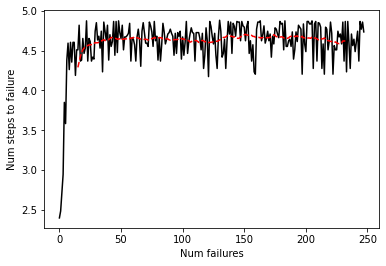

In [22]:
"""
CS 229 Machine Learning, Fall 2017
Problem Set 4
Question: Reinforcement Learning: The inverted pendulum
Author: Sanyam Mehra, sanyam@stanford.edu
"""
from __future__ import division, print_function
from data.cart_pole import CartPole, Physics
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import lfilter

"""
Parts of the code (cart and pole dynamics, and the state
discretization) are inspired from code available at the RL repository
http://www-anw.cs.umass.edu/rlr/domains.html

This file controls the pole-balancing simulation. You only need to
write code in between places marked
###### BEGIN YOUR CODE ######
###### END YOUR CODE ######

Briefly, the cart-pole system is described in `cart_pole.py`. The main
simulation loop in this file calls the `simulate()` function for
simulating the pole dynamics, `get_state()` for discretizing the
otherwise continuous state space in discrete states, and `show_cart()`
for display.

Some useful parameters are listed below:

`NUM_STATES`: Number of states in the discretized state space
You must assume that states are numbered 0 through `NUM_STATES` - 1. The
state numbered `NUM_STATES` - 1 (the last one) is a special state that
marks the state when the pole has been judged to have fallen (or when
the cart is out of bounds). However, you should NOT treat this state
any differently in your code. Any distinctions you need to make between
states should come automatically from your learning algorithm.

After each simulation cycle, you are supposed to update the transition
counts and rewards observed. However, you should not change either
your value function or the transition probability matrix at each
cycle.

Whenever the pole falls, a section of your code below will be
executed. At this point, you must use the transition counts and reward
observations that you have gathered to generate a new model for the MDP
(i.e. transition probabilities and state rewards). After that, you
must use value iteration to get the optimal value function for this MDP
model.

`TOLERANCE`: Controls the convergence criteria for each value iteration
run. In value iteration, you can assume convergence when the maximum
absolute change in the value function at any state in an iteration
becomes lower than `TOLERANCE.

You need to write code that chooses the best action according
to your current value function, and the current model of the MDP. The
action must be either 0 or 1 (corresponding to possible directions of
pushing the cart)

Finally, we assume that the simulation has converged when
`NO_LEARNING_THRESHOLD` consecutive value function computations all
converged within one value function iteration. Intuitively, it seems
like there will be little learning after this, so we end the simulation
here, and say the overall algorithm has converged.


Learning curves can be generated by calling a code snippet at the end
(it assumes that the learning was just executed, and the array
`time_steps_to_failure` that records the time for which the pole was
balanced before each failure are in memory). `num_failures` is a variable
that stores the number of failures (pole drops / cart out of bounds)
till now.

Other parameters in the code are described below:

`GAMMA`: Discount factor to be used

The following parameters control the simulation display; you dont
really need to know about them:

`pause_time`: Controls the pause between successive frames of the
display. Higher values make your simulation slower.
`min_trial_length_to_start_display`: Allows you to start the display only
after the pole has been successfully balanced for at least this many
trials. Setting this to zero starts the display immediately. Choosing a
reasonably high value (around 100) can allow you to rush through the
initial learning quickly, and start the display only after the
performance is reasonable.
"""


# Simulation parameters
pause_time = 0.0001
min_trial_length_to_start_display = 100
display_started = min_trial_length_to_start_display == 0

NUM_STATES = 163
NUM_ACTIONS = 2
GAMMA = 0.995
TOLERANCE = 0.01
NO_LEARNING_THRESHOLD = 20

# Time cycle of the simulation
time = 0

# These variables perform bookkeeping (how many cycles was the pole
# balanced for before it fell). Useful for plotting learning curves.
time_steps_to_failure = []
num_failures = 0
time_at_start_of_current_trial = 0

# You should reach convergence well before this
max_failures = 500

# Initialize a cart pole
cart_pole = CartPole(Physics())

# Starting `state_tuple` is (0, 0, 0, 0)
# x, x_dot, theta, theta_dot represents the actual continuous state vector
x, x_dot, theta, theta_dot = 0.0, 0.0, 0.0, 0.0
state_tuple = (x, x_dot, theta, theta_dot)

# `state` is the number given to this state, you only need to consider
# this representation of the state
state = cart_pole.get_state(state_tuple)
# if min_trial_length_to_start_display == 0 or display_started == 1:
#     cart_pole.show_cart(state_tuple, pause_time)

# Perform all your initializations here:
# Assume no transitions or rewards have been observed.
# Initialize the value function array to small random values (0 to 0.10,
# say).
# Initialize the transition probabilities uniformly (ie, probability of
# transitioning for state x to state y using action a is exactly
# 1/NUM_STATES).
# Initialize all state rewards to zero.

###### BEGIN YOUR CODE ######----------------------------------------------------------
# TODO:
#raise NotImplementedError('Initializations not implemented')

# init value function
V = 0.1*np.random.rand(NUM_STATES)
# init transition probabilities
P_sa = np.ones((NUM_STATES, NUM_ACTIONS, NUM_STATES)) / NUM_STATES
#P_sa = np.ones((NUM_STATES, NUM_STATES, NUM_STATES)) / NUM_STATES
# init all state rewards
R_s = np.zeros(NUM_STATES)


# record the number of times `state, action, new_state` occurs
transition_count = np.zeros((NUM_STATES, NUM_ACTIONS, NUM_STATES))
# record the rewards for every `new_state`
reward_tot = np.zeros(NUM_STATES)
# record the number of time `new_state` was reached
reward_count = np.zeros(NUM_STATES)

###### END YOUR CODE ######----------------------------------------------------------

# This is the criterion to end the simulation.
# You should change it to terminate when the previous
# 'NO_LEARNING_THRESHOLD' consecutive value function computations all
# converged within one value function iteration. Intuitively, it seems
# like there will be little learning after this, so end the simulation
# here, and say the overall algorithm has converged.

consecutive_no_learning_trials = 0
while consecutive_no_learning_trials < NO_LEARNING_THRESHOLD:

    # Write code to choose action (0 or 1).
    # This action choice algorithm is just for illustration. It may
    # convince you that reinforcement learning is nice for control
    # problems!Replace it with your code to choose an action that is
    # optimal according to the current value function, and the current MDP
    # model.
    ###### BEGIN YOUR CODE ######----------------------------------------------------------
    # TODO:
    #raise NotImplementedError('Action choice not implemented')
    # action = 0 if np.random.uniform() < 0.5 else 1
    action =  np.argmax(P_sa[state]@V)
    ###### END YOUR CODE ######----------------------------------------------------------

    # Get the next state by simulating the dynamics
    state_tuple = cart_pole.simulate(action, state_tuple)
    # x, x_dot, theta, theta_dot = state_tuple

    # Increment simulation time
    time = time + 1

    # Get the state number corresponding to new state vector
    new_state = cart_pole.get_state(state_tuple)
    # if display_started == 1:
    #     cart_pole.show_cart(state_tuple, pause_time)

    # reward function to use - do not change this!
    if new_state == NUM_STATES - 1:
        R = -1
    else:
        R = 0

    # Perform model updates here.
    # A transition from `state` to `new_state` has just been made using
    # `action`. The reward observed in `new_state` (note) is `R`.
    # Write code to update your statistics about the MDP i.e. the
    # information you are storing on the transitions and on the rewards
    # observed. Do not change the actual MDP parameters, except when the
    # pole falls (the next if block)!

    ###### BEGIN YOUR CODE ######----------------------------------------------------------
    # TODO:
    #raise NotImplementedError('Update T and R not implemented')
    # record the number of times `state, action, new_state` occurs
    transition_count[state, action, new_state] += 1
    # record the rewards for every `new_state`
    reward_tot[new_state] += R
    # record the number of time `new_state` was reached
    reward_count[new_state] += 1
    ###### END YOUR CODE ######----------------------------------------------------------

    # Recompute MDP model whenever pole falls
    # Compute the value function V for the new model
    if new_state == NUM_STATES - 1:

        # Update MDP model using the current accumulated statistics about the
        # MDP - transitions and rewards.
        # Make sure you account for the case when a state-action pair has never
        # been tried before, or the state has never been visited before. In that
        # case, you must not change that component (and thus keep it at the
        # initialized uniform distribution).

        ###### BEGIN YOUR CODE ######----------------------------------------------------------
        # TODO:
        #raise NotImplementedError('MDP  T and R update not implemented')
        
        # total count of times each state and action occured
        counts = transition_count.sum(axis = 2)
        pos_counts = counts > 0 # only chagne P_sa where model spanned
        # update P_sa
        P_sa[pos_counts] = transition_count[pos_counts] / counts[pos_counts].reshape(-1,1)
        
        # update rewards
        pos_rewards = reward_count > 0
        #**** line 236
        R_s[pos_rewards] = reward_tot[pos_rewards] / reward_count[pos_rewards]
        ###### END YOUR CODE ######----------------------------------------------------------

        # Perform value iteration using the new estimated model for the MDP.
        # The convergence criterion should be based on `TOLERANCE` as described
        # at the top of the file.
        # If it converges within one iteration, you may want to update your
        # variable that checks when the whole simulation must end.
        
        ###### BEGIN YOUR CODE ######----------------------------------------------------------
        # TODO:
        #raise NotImplementedError('Value iteration choice not implemented')
        
        count = 0
        delta = float('inf')
        while delta >= TOLERANCE:
            V_hold = V.copy()
            # update V
            V =  R_s + GAMMA * np.max(np.sum(P_sa * V, axis=2), axis=1)
            # calculate delta
            delta = np.abs(V-V_hold).max()
            count+=1
        
        # incrament consecutive_no_learning_trials if the solution only updates within TOLERENCE
        if count == 1:
            consecutive_no_learning_trials += 1
        else:
            consecutive_no_learning_trials = 0
            
        ###### END YOUR CODE ######----------------------------------------------------------

    # Do NOT change this code: Controls the simulation, and handles the case
    # when the pole fell and the state must be reinitialized.
    if new_state == NUM_STATES - 1:
        num_failures += 1
        if num_failures >= max_failures:
            break
        print('[INFO] Failure number {}'.format(num_failures))
        time_steps_to_failure.append(time - time_at_start_of_current_trial)
        # time_steps_to_failure[num_failures] = time - time_at_start_of_current_trial
        time_at_start_of_current_trial = time

        if time_steps_to_failure[num_failures - 1] > min_trial_length_to_start_display:
            display_started = 1

        # Reinitialize state
        # x = 0.0
        x = -1.1 + np.random.uniform() * 2.2
        x_dot, theta, theta_dot = 0.0, 0.0, 0.0
        state_tuple = (x, x_dot, theta, theta_dot)
        state = cart_pole.get_state(state_tuple)
    else:
        state = new_state

# plot the learning curve (time balanced vs. trial)
log_tstf = np.log(np.array(time_steps_to_failure))
plt.plot(np.arange(len(time_steps_to_failure)), log_tstf, 'k')
window = 30
w = np.array([1/window for _ in range(window)])
weights = lfilter(w, 1, log_tstf)
x = np.arange(window//2, len(log_tstf) - window//2)
plt.plot(x, weights[window:len(log_tstf)], 'r--')
plt.xlabel('Num failures')
plt.ylabel('Num steps to failure')
plt.show()
